In [12]:
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz, group_delay
from ellpy.cutting_plane import cutting_plane_dc, cutting_plane_q
from ellpy.ell import ell
from ellpy.oracles.spectral_fact import spectral_fact
from ellpy.oracles.lowpass_oracle import lowpass_oracle
from ellpy.oracles.csdlowpass_oracle import csdlowpass_oracle
from pycsd.csd import to_csdfixed

import logging
import sys

from ellpy import __version__

__author__ = "Wai-Shing Luk"
__copyright__ = "Wai-Shing Luk"
__license__ = "mit"

_logger = logging.getLogger(__name__)


def create_lowpass_case(N=48):
    """[summary]

    Keyword Arguments:
        N (int): [description] (default: {48})

    Returns:
        [type]: [description]
    """
    wpass = 0.12 * np.pi  # end of passband
    wstop = 0.20 * np.pi  # start of stopband
    delta0_wpass = 0.025
    delta0_wstop = 0.125
    # maximum passband ripple in dB (+/- around 0 dB)
    delta = 20 * np.log10(1 + delta0_wpass)
    # stopband attenuation desired in dB
    delta2 = 20 * np.log10(delta0_wstop)

    # *********************************************************************
    # optimization parameters
    # *********************************************************************
    # rule-of-thumb discretization (from Cheney's Approximation Theory)
    m = 15 * N
    w = np.linspace(0, np.pi, m)  # omega

    # A is the matrix used to compute the power spectrum
    # A(w,:) = [1 2*cos(w) 2*cos(2*w) ... 2*cos(N*w)]
    An = 2 * np.cos(np.outer(w, np.arange(1, N)))
    A = np.concatenate((np.ones((m, 1)), An), axis=1)

    # passband 0 <= w <= w_pass
    ind_p = np.where(w <= wpass)[0]  # passband
    Lp = 10**(-delta / 20)
    Up = 10**(+delta / 20)
    Ap = A[ind_p, :]

    # stopband (w_stop <= w)
    ind_s = np.where(wstop <= w)[0]  # stopband
    Sp = 10**(delta2 / 20)
    As = A[ind_s, :]
    ind_beg = ind_p[-1]
    ind_end = ind_s[0]
    Anr = A[range(ind_beg + 1, ind_end), :]

    Lpsq = Lp**2
    Upsq = Up**2
    Spsq = Sp**2

    P = lowpass_oracle(Ap, As, Anr, Lpsq, Upsq)
    return P, Spsq


def create_csdlowpass_case(N=48, nnz=8):
    """[summary]

    Keyword Arguments:
        N (int): [description] (default: {48})
        nnz (int): [description] (default: {8})

    Returns:
        [type]: [description]
    """
    P, Spsq = create_lowpass_case(N)
    Pcsd = csdlowpass_oracle(nnz, P)
    return Pcsd, Spsq


def plot_lowpass_result(rf, Spsqf, rcsd, Spsqcsd):
    # *********************************************************************
    # plotting routines
    # *********************************************************************
    # frequency response of the designed filter, where j = sqrt(-1)
    h_spf = spectral_fact(rf)  # from CVX distribution, Examples subdirectory
    h_spcsd = spectral_fact(rcsd)
    # I'm not sure how accurate this function performs!!!
    hf = h_spf
    print("h = ", hf)
    # compute the min attenuation in the stopband (convert to original vars)
    Ustop = 20 * np.log10(np.sqrt(Spsqf))

    print('Min attenuation in the stopband is ', Ustop, ' dB.')

    freq = [0, 0.12, 0.2, 1.0]
    desired = [1, 0]
    h_linear = remez(151, freq, desired, Hz=2.)
    # h_min_hom = minimum_phase(h_linear, method='homomorphic')

    # fig, axs = plt.subplots(4, figsize=(4, 8))
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    axs = (ax1, ax2, ax3, ax4)
    for h, style, color in zip((h_spcsd, h_spf), ('-', '-'),
                               ('k', 'r')):
        # if feasible:
        w, H = freqz(h)
        w, gd = group_delay((h, 1))
        w /= np.pi
        axs[0].plot(h, color=color, linestyle=style)
        axs[1].plot(w, np.abs(H), color=color, linestyle=style)
        axs[2].plot(w,
                    ne.evaluate('20 * log10(abs(H))'),
                    color=color,
                    linestyle=style)
        axs[3].plot(w, gd, color=color, linestyle=style)

    for ax in axs:
        ax.grid(True, color='0.5')
        ax.fill_between(freq[1:3], *ax.get_ylim(), color='#ffeeaa', zorder=1)

    axs[0].set(xlim=[0, len(h_linear) - 1],
               ylabel='Amplitude',
               xlabel='Samples')
    axs[1].legend(['Our(csd)', 'Our'], title='Phase')
    for ax, ylim in zip(axs[1:], ([0, 1.1], [-80, 10], [-60, 60])):
        ax.set(xlim=[0, 1], ylim=ylim, xlabel='Frequency')
    axs[1].set(ylabel='Magnitude')
    axs[2].set(ylabel='Magnitude (dB)')
    axs[3].set(ylabel='Group delay')
    plt.tight_layout()
    plt.show()


def setup_logging(loglevel):
    """Setup basic logging

    Args:
      loglevel (int): minimum loglevel for emitting messages
    """
    logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
    logging.basicConfig(level=loglevel, stream=sys.stdout,
                        format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

    
def main(N, nnz):
    """Main entry point allowing external calls

    Args:
      args ([str]): command line parameter list
    """
    setup_logging(logging.INFO)
    _logger.debug("Starting crazy calculations...")
    # print("The {}-th Fibonacci number is {}".format(args.n, fib(args.n)))

    r0 = np.zeros(N)  # initial x0
    r0[0] = 0
    E = ell(40., r0)
    P, Spsq = create_lowpass_case(N)
    rf, t, ell_info = cutting_plane_dc(P, E, Spsq)

    if not ell_info.feasible:
        _logger.error("Configuration is not feasible")
    else:
        Spsqf = t
        hf = spectral_fact(rf)
        # print(ell_info.num_iters, ell_info.feasible, ell_info.status)
        print(hf)

    r0 = np.zeros(N)  # initial x0
    r0[0] = 0
    E = ell(40., r0)
    P, Spsq = create_csdlowpass_case(N, nnz)
    rcsd, t, ell_info = cutting_plane_q(P, E, Spsq)

    if not ell_info.feasible:
        _logger.error("Configuration is not feasible")
    else:
        Spsqcsd = t
        h_spcsd = spectral_fact(rcsd)
        h_spcsd_str = [to_csdfixed(hi, nnz) for hi in h_spcsd]

        # print(ell_info.num_iters, ell_info.feasible, ell_info.status)
        print(h_spcsd_str)
        # assert ell_info.feasible
        plot_lowpass_result(rf, Spsqf, rcsd, Spsqcsd)

    _logger.info("Script ends here")


[2020-03-16 16:52:56] DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
[2020-03-16 16:52:56] DEBUG:__main__:Starting crazy calculations...
[ 0.0260435   0.03822286  0.06201715  0.08842136  0.11443477  0.13499247
  0.14872362  0.15106218  0.14074792  0.117883    0.08659776  0.0501345
  0.01369978 -0.0177448  -0.04086187 -0.05161965 -0.05146201 -0.04207838
 -0.0252937  -0.00690205  0.00944784  0.02160145  0.02665536  0.02693699
  0.02099662  0.01241063  0.00249205 -0.00428252 -0.00984526 -0.01178474
 -0.01179095 -0.01307437]
['0.0000+00-0-0+000+0-00+00-', '0.0000+0+0000-0-00-0+000000-0000+', '0.000+000000+00-00-0+0-000-0+', '0.00+0-00-0-000+000-00+00+', '0.00+00-0+0+00-0-0000+00+', '0.00+00+0-0-00+0+0-00-', '0.00+0+0-0000+0-000+0+0-', '0.00+0+0-0+000+00+00000+000+', '0.00+00+000-000+00+0+0+0+', '0.00+000-0000000+0+00-000-0+0-', '0.00+0-0-000-0+0+0+00-', '0.000+0-00+000-0+0+000-00+', '0.00000+0-0+0000+000000-0-00+0+', '0.00000-0-0+0-000+00-00

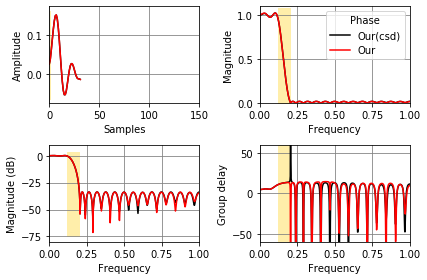

[2020-03-16 16:53:00] INFO:__main__:Script ends here


In [13]:
%matplotlib inline
N = 32
nnz = 8
main(N,nnz)